**作业**
- 研究一些股票，找出相关系数大于0.8的股票,若没有，计算最大的相关系数
- 假设初始资金100万，设计投资策略，并比较策略和大盘的收益
- 画出资金每日增长／减少曲线[一条是投资策略的，一条是按大盘走势的]

1.处于相同行业的股票通常具有较大的相关系数，为此选择了白酒行业、石油行业、银行业的代表性大盘股进行相关系数的分析。

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
from jqdatasdk import *
auth('18801231748','231748') #加载JoinQuant聚宽数据库

auth success 


In [4]:
security_list=['000858.XSHE','600519.XSHG']
#股票列表：000858五粮液，600519贵州茅台

In [5]:
data=get_price(security_list, start_date='2016-01-01', end_date='2019-08-30', 
               frequency='daily', fields=['close'], skip_paused=False, fq='pre')
#使用2016年1月1日至2019年8月30日的每日收盘价数据，股价为前复权，且停牌时股价以停牌前计算

In [6]:
closeprice=data['close'] #closeprice为股票收盘价数据
returns=closeprice.pct_change().dropna() #returns为股票日收益率数据

In [7]:
returns.corr()

,000858.XSHE,600519.XSHG
000858.XSHE,1.00000,0.78688
600519.XSHG,0.78688,1.00000


可以发现，白酒行业龙头贵州茅台与五粮液的相关系数达到了0.78688，已经非常高了，但没有达到0.8

In [8]:
security_list=['600028.XSHG','601857.XSHG']
#股票列表：600028中国石化，601857中国石油

In [9]:
data=get_price(security_list, start_date='2016-01-01', end_date='2019-08-30', 
               frequency='daily', fields=['close'], skip_paused=False, fq='pre')
#使用2016年1月1日至2019年8月30日的每日收盘价数据，股价为前复权，且停牌时股价以停牌前计算

In [10]:
closeprice=data['close'] #closeprice为股票收盘价数据
returns=closeprice.pct_change().dropna() #returns为股票日收益率数据

In [11]:
returns.corr()

,600028.XSHG,601857.XSHG
600028.XSHG,1.000000,0.761908
601857.XSHG,0.761908,1.000000


可以发现，两桶油的相关系数达到了0.761908，也没有达到0.8

In [12]:
security_list=['601288.XSHG','601398.XSHG','601939.XSHG','601988.XSHG']
#股票列表：601288农业银行，601398工商银行，601939建设银行，601988中国银行

In [13]:
data=get_price(security_list, start_date='2016-01-01', end_date='2019-08-30', 
               frequency='daily', fields=['close'], skip_paused=False, fq='pre')
#使用2016年1月1日至2019年8月30日的每日收盘价数据，股价为前复权，且停牌时股价以停牌前计算

In [14]:
closeprice=data['close'] #closeprice为股票收盘价数据
returns=closeprice.pct_change().dropna() #returns为股票日收益率数据

In [15]:
returns.corr()

,601288.XSHG,601398.XSHG,601939.XSHG,601988.XSHG
601288.XSHG,1.000000,0.845102,0.822104,0.834127
601398.XSHG,0.845102,1.000000,0.885784,0.832296
601939.XSHG,0.822104,0.885784,1.000000,0.834819
601988.XSHG,0.834127,0.832296,0.834819,1.000000


可以发现，四大行之间的相关系数均超过了0.8。

In [16]:
get_query_count()

{'total': 1000000, 'spare': 992848}

2.假设初始资金100万，设计投资策略，并比较策略和大盘的收益

以市场常见的“追涨杀跌”现象作为投资策略，即股价上涨时加仓，股价下跌时减仓，为了进行量化，采用N日收盘均价与当日收盘价进行比较，若当日收盘价向上穿过N日收盘均价，代表上涨势头得到确认，进行加仓；若当日收盘价向下穿过N日收盘均价，代表下跌势头得到确认，进行减仓。投资的标的设置为沪深300指数。为简便起见，加仓视为全仓，减仓视为空仓。

In [17]:
HS300=get_price('000300.XSHG', start_date='2016-01-01', end_date='2019-08-30', 
               frequency='daily', fields=['close'], skip_paused=False, fq='pre')
#使用2016年1月1日至2019年8月30日的每日收盘价数据，股价为前复权，且停牌时股价以停牌前计算

In [18]:
#计算沪深300收盘价的N日收盘均价
N=20
HS300MA=HS300.copy()
for i in range(1,N):
    HS300MA=HS300MA+HS300.shift(i)
HS300MA=HS300MA/N 

In [19]:
#sigh代表沪深300收盘价是否高于N日收盘均价
sign=HS300>HS300MA
sign=np.array(sign).T
sign=sign.tolist()
sign=sign[0]


In [20]:
#HS300returns代表沪深300指数的日收益率
HS300returns=HS300.pct_change()
HS300returns=np.array(HS300returns).T
HS300returns=HS300returns.tolist()
HS300returns=HS300returns[0]

In [21]:
#初始时现金money持有100万元，初始股票价值stockvalue为0，总资产用allaseet表示，最初本金为initialasset
initialasset=1000000
money=[0 for _ in range(len(HS300))]
stockvalue=[0 for _ in range(len(HS300))]
allasset=[0 for _ in range(len(HS300))]
for i in range(N):
    money[i]=initialasset
    stockvalue[i]=0
    allasset[i]=stockvalue[i]+money[i]
flag1=0
flag2=0
for i in range(N,len(HS300)):
    if (sign[i]==True and sign[i-1]==False): #当日出现收盘价向上穿过N日收盘均价的买入信号
        stockvalue[i]=money[i-1]
        money[i]=0
        allasset[i]=stockvalue[i]+money[i]
        flag1+=1
    elif (sign[i]==False and sign[i-1]==True): #当日出现收盘价向下穿过N日收盘价均价的卖出信号
        money[i]=stockvalue[i-1]*(1+HS300returns[i])
        stockvalue[i]=0
        allasset[i]=stockvalue[i]+money[i]
        flag2+=1
    else:
        money[i]=money[i-1]
        stockvalue[i]=stockvalue[i-1]*(1+HS300returns[i])
        allasset[i]=stockvalue[i]+money[i]
print("进行加仓操作",flag1,"次，进行减仓操作",flag2,"次")


进行加仓操作 46 次，进行减仓操作 45 次


In [22]:
#HS300asset代表一直持有沪深300指数，不进行加仓减仓
HS300asset=[1000000]
for i in range(1,len(HS300)):
    HS300asset.append(HS300asset[i-1]*(1+HS300returns[i]))

3.画出资金每日增长／减少曲线[一条是投资策略的，一条是按大盘走势的]

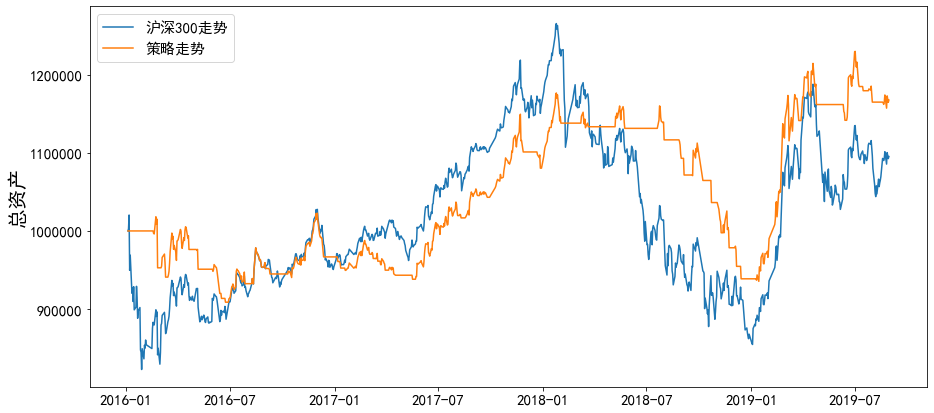

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(15,7))
plt.plot(HS300.index,HS300asset,label='沪深300走势')
plt.plot(HS300.index,allasset,label='策略走势')
plt.ylabel('总资产', color='black',size=20)
plt.tick_params(labelsize=15)
plt.axis('tight') 
plt.legend(prop={'size': 15})
plt.show()

从图中可以看出，该策略在熊市中具有更小的回撤，能在下跌行情中起到及时止损的作用。